## Introduction

Presenter: _James Byrne_ - Research Software Engineer at the British Antarctic Survey (BAS)
Additional workshop presenters: 
* Tom Andersson - Lead IceNet Researcher (BAS / Alan Turing Institute (ATI))
* James Robinson - RSE (ATI) and IceNet developer 

### Abstract

Global warming has caused vast amounts of Arctic sea ice to melt, with severe impacts for local people and ecosystems. Despite this, forecasting sea ice accurately is a major unsolved challenge. Our team of researchers developed a sea ice forecasting AI system, 'IceNet', which pushed the boundaries of forecasting ability and speed [1]. We have since developed a software ecosystem for operating IceNet in real-time, for both poles, on a daily timescale.

### Summary

Please note the following: 

* ___This is a whistlestop tour___
* __Following it all isn't necessary__
* __Q&A__

__IceNet is a tale of two halves this being the second...__

#### What we'll cover

<img alt="The bubbles of IceNet" style="text-align:center" src="bubbles.png" />

1. Pipeline and model operation
  1. Source data stores
  1. Data loader stores
  1. Visualising data
  1. Creating training datasets
  1. Training and predicting
  1. Forecast analysis
1. Environments and Extensions
  1. Environments
  1. Extensions
1. Integrations and Applications 
  1. Framework
  1. Ecosystem
1. Future
1. Conclusions
1. Q&A

[1]: https://www.nature.com/articles/s41467-021-25257-4

## Architectures

### Model

<img src="model.png" alt="Model architecture" style="width:800px" />

#### Three pro's and three con's of a purely research oriented model

### Pipeline

<img src="pipeline.png" alt="Pipeline architecture" />

### Framework

<img alt="Framework architecture" src="framework.png" style="width:800px" />

### Ecosystem

<img alt="Ecosystem architecture" src="ecosystem.png" style="width:800px" /> 

### Some cheeky setup

In [2]:
import datetime as dt
import glob
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

from IPython.display import HTML

from icenet2.process.forecasts import broadcast_forecast
from icenet2.plotting.video import get_dataarray_from_files, xarray_to_video

%matplotlib inline

2022-03-21 14:20:06.731880: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
if os.path.exists("aiuk-demo.ipynb"):
    os.chdir("..")
print("Running in {}".format(os.getcwd()))

Running in /data/hpcdata/users/jambyr/icenet/aiuk-2022


In [16]:
!git config --get 'remote.origin.url'

git@github.com:antarctica/IceNet-Pipeline.git


In [17]:
!./install_env.sh aiuk-demo

In [18]:
# git clone git@github.com:JimCircadian/icenet2.git --depth 1 -b linear_trend_update ../icenet2-aiuk
!pip install ../icenet2-aiuk

Processing /data/hpcdata/users/jambyr/icenet/icenet2-aiuk
  Preparing metadata (setup.py) ... done
  Created wheel for icenet2: filename=icenet2-0.1.0a1-py2.py3-none-any.whl size=76409 sha256=6d4e7ed4befdaf8b51e158821375ccab5e90ad9264781edb587d7c4a769a0743
  Stored in directory: /users/jambyr/.cache/pip/wheels/3f/68/27/79b9c758a8fa4a6c9d3b8dafc99c2d4caecc3ef09d3abcd701
Successfully built icenet2
  Attempting uninstall: icenet2
    Found existing installation: icenet2 0.1.0a1
    Uninstalling icenet2-0.1.0a1:
      Successfully uninstalled icenet2-0.1.0a1


## Source data stores

![Pipeline architecture](pipeline-data.png)

In [19]:
!readlink data
!ls data/

../data/
cmip6  era5  mars.hres	masks  osisaf


In [20]:
!icenet_data_masks south

INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200001021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_01.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200002021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_02.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200003021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_03.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200004021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_04.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200005021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_05.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200006021200.nc already exists
INFO:root:Saving ./data/masks/sh/masks/active_grid_cell_mask_06.npy
INFO:root:siconca ice_conc_sh_ease2-250_cdr-v2p0_200007021200.nc already exists
INFO:root:Saving ./data/masks/sh

In [11]:
!icenet_data_era5 south -w 1 -c cdsapi 2012-12-28 2017-12-31

INFO:root:ERA5 Data Downloading
INFO:root:Building request(s), downloading and daily averaging from ERA5 API
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for tas
INFO:root:No dates needing downloading for ta

In [12]:
!icenet_data_sic south 2012-12-28 2017-12-31

INFO:root:OSASIF-SIC Data Downloading
INFO:root:Downloading SIC datafiles to .temp intermediates...
/data/hpcdata/users/jambyr/miniconda3/envs/aiuk-demo/lib/python3.8/site-packages/icenet2/data/sic/osisaf.py:262: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if el in self._invalid_dates:
INFO:root:2012_12_28 file exists, skipping
INFO:root:2012_12_29 file exists, skipping
INFO:root:2012_12_30 file exists, skipping
INFO:root:2012_12_31 file exists, skipping
INFO:root:2013_01_01 file exists, skipping
INFO:root:2013_01_02 file exists, skipping
INFO:root:2013_01_03 file exists, skipping
INFO:root:2013_01_04 file exists, skipping
INFO:root:2013_01_05 file exists, skipping
INFO:root:2013_01_06 file exists, skipping
INFO:root:2013_01_07 file exists, skipping
INFO:root:2013_01_08 file exists, ski

At time of writing there are the following downloaders: 

* `icenet_data_era5` - downloads [ERA5 reanalysis](https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset&keywords=((%20%22Product%20type:%20Reanalysis%22%20) data using either the CDS Toolbox or direct API
* `icenet_data_cmip` - downloads the prescribed experiments from [CMIP6](https://esgf-node.llnl.gov/search/cmip6/) for the original IceNet paper runs
* `icenet_data_hres` - downloads up to date [forecast generated data from the ECMWF real time forecast API](https://www.ecmwf.int/en/forecasts/datasets/catalogue-ecmwf-real-time-products)
* `icenet_data_sic` - downloads [OSISAF sea-ice concentration (SIC) data](https://osisaf-hl.met.no/v2p1-sea-ice-index)

```python
from icenet2.data.sic.mask import Masks
from icenet2.data.interfaces.cds import ERA5Downloader
from icenet2.data.sic.osisaf import SICDownloader

masks = Masks(north=False, south=True)
era5 = ERA5Downloader(
    var_names=["tas", "ta", "tos", "psl", "zg", "hus", "rlds", "rsds", "uas", "vas"],
    pressure_levels=[None, [500], None, None, [250, 500], [1000], None, None, None, None],
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2012-12-28", "2017-12-31", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    use_toolbox=False
)
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           pd.date_range("2012-12-28", "2017-12-31", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
)
masks.generate(save_polarhole_masks=False)
era5.download()
sic.download()
era5.regrid()
era5.rotate_wind_data()
```

## Data loader store

![Pipeline architecture](pipeline-process.png)

In [ ]:
!icenet_process_era5 aiuk_run south \
    -ns 2013-1-1 -ne 2016-12-31 \
    -vs 2017-1-1,2017-8-1 -ve 2017-2-14,2017-8-14 \
    -ts 2017-4-1 -te 2017-4-14 -l 3

In [ ]:
!icenet_process_sic aiuk_run south \
    -ns 2013-1-1 -ne 2016-12-31 \
    -vs 2017-1-1,2017-8-1 -ve 2017-2-14,2017-8-14 \
    -ts 2017-4-1 -te 2017-4-1 -l 3

In [ ]:
!icenet_process_metadata aiuk_run south

```python
from icenet2.data.processors.era5 import IceNetERA5PreProcessor
from icenet2.data.processors.meta import IceNetMetaPreProcessor
from icenet2.data.processors.osi import IceNetOSIPreProcessor

processed_name = "aiuk_run"

processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2013-1-1", "2016-12-31")],
    val=[pd.to_datetime(el) for el in 
         list(pd.date_range("2017-1-1", "2017-2-14")) + 
         list(pd.date_range("2017-8-1", "2020-8-14"))],
    test=[pd.to_datetime(el) for el in pd.date_range("2017-4-1", "2017-4-14")],
)

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "ta500", "tos", "psl", "zg500", "zg250", "rsds", "rlds",
     "hus1000"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)
osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=["siconca"],
    linear_trend_days=93,
    north=False,
    south=True
)
meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)
pp.init_source_data(
    lag_days=3,
)
osi.init_source_data(
    lag_days=3,
    lead_days=93,
)
pp.process()
osi.process()
meta.process()
```

### Visualising data stores

In [21]:
np_dfs = glob.glob("processed/aiuk_run/osisaf/sh/siconca/2017_04_*.npy")
anim = xarray_to_video(get_dataarray_from_files(np_dfs, numpy=True), 10, figsize=4)
HTML(anim.to_html5_video())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation


### Creating training dataset

```bash
icenet_dataset_create -l 3 -w 16 -fn aiuk_dataset aiuk_run south
```

In [22]:
!icenet_dataset_create -c -l 3 -fn aiuk_dataset_configuration aiuk_run south

2022-03-21 15:47:34.933166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
INFO:root:Creating path: ./network_datasets/aiuk_dataset_configuration
INFO:root:Loading configuration loader.aiuk_run.json
INFO:root:Writing dataset configuration without data generation
INFO:root:1461 train dates in total, NOT generating cache data.
INFO:root:59 val dates in total, NOT generating cache data.
INFO:root:14 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.aiuk_dataset_configuration.json


### Training and predicting

```bash
icenet_train aiuk_dataset aiuk_testrun 42 -b 4 -e 5 -m -qs 4 -w 4 -n 0.6
```

```bash
366/366 - 218s - loss: 15.1218 - mae: 24.2947 - rmse: 33.9091 - mse: 1150.1542 - val_loss: 13.9713 - val_mae: 24.2918 - val_rmse: 33.2628 - val_mse: 1106.9816

Epoch 00005: val_rmse improved from 34.42699 to 33.26282, saving model to ./results/networks/aiuk_testrun/aiuk_testrun.network_aiuk_dataset.42.h5
INFO:root:Saving network to: ./results/networks/aiuk_testrun/aiuk_testrun.network_aiuk_dataset.42.h5

wandb: Waiting for W&B process to finish... (success).
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:    epoch ▁▃▅▆█
wandb:     loss █▄▂▁▁
wandb:       lr ▁▁▁▁▁
wandb:      mae █▅▃▂▁
wandb:      mse █▄▃▁▁
wandb:     rmse █▄▃▁▁
wandb: val_loss █▃▃▁▁
wandb:  val_mae █▆▃▂▁
wandb:  val_mse █▆▃▂▁
wandb: val_rmse █▆▃▂▁
wandb: 
wandb: Run summary:
wandb:    best_epoch 4
wandb: best_val_rmse 33.26282
wandb:         epoch 4
wandb:          loss 15.12178
wandb:            lr 0.0001
wandb:           mae 24.29469
wandb:           mse 1150.15417
wandb:          rmse 33.90914
wandb:      val_loss 13.97132
wandb:       val_mae 24.29184
wandb:       val_mse 1106.98157
wandb:      val_rmse 33.26282
wandb: 
wandb: Synced aiuk_testrun: https://wandb.ai/jambyr/icenet2/runs/3aj4det4
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20220321_124352-3aj4det4/logs
```

In [4]:
!icenet_train aiuk_dataset aiuk_testrun 42 -b 4 -e 5 -m -qs 4 -w 4 -n 0.6 \
    -p ./results/networks/aiuk_testrun/aiuk_testrun.network_aiuk_dataset.42.h5

2022-03-21 14:20:29.484950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
INFO:root:Setting seed value 42
wandb: Currently logged in as: jambyr (use `wandb login --relogin` to force relogin)
2022-03-21 14:20:34.809269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
wandb: Tracking run with wandb version 0.12.11
wandb: Run data is saved locally in /data/hpcdata/users/jambyr/icenet/aiuk-2022/wandb/run-20220321_142033-2blh48u8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run aiuk_testrun
wandb: ⭐️ View project at https://wandb.ai/jambyr/icenet2
wandb: 🚀 View run at https://wandb.ai/jambyr/icenet2/runs/2blh48u8
INFO:root:Hyperparameters: {'seed': 42, 'learning_rate': 0.0001, 'filter_size': 3, 'n_filters_factor': 0.6, 'lr_10e_decay_fac': 1.0, 'lr_decay': -0.0, 'lr_decay_start': 10, 'lr_decay_end': 30, 'batch_size': 4}
INFO:root:Load

In [6]:
!./loader_test_dates.sh aiuk_run | tee testdates

2017-04-01
2017-04-02
2017-04-03
2017-04-04
2017-04-05
2017-04-06
2017-04-07
2017-04-08
2017-04-09
2017-04-10
2017-04-11
2017-04-12
2017-04-13
2017-04-14


In [7]:
!icenet_predict -n 0.6 -t \
    aiuk_dataset aiuk_testrun example_south_forecast 42 testdates

2022-03-21 14:45:17.148976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
INFO:root:Loading configuration ./dataset_config.aiuk_dataset.json
INFO:root:Loading configuration loader.aiuk_run.json
INFO:root:Datasets: 183 train, 8 val and 2 test filenames
2022-03-21 14:45:18.770197: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-21 14:45:18.772461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-21 14:45:18.800841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro P4000 computeCapability: 6.1
coreClock: 1.48GHz coreCount: 14 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 226.62GiB/s
2022-03-21 14:45:18.800911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic li

In [8]:
!icenet_output -o results/predict example_south_forecast aiuk_dataset testdates

2022-03-21 14:46:24.407084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
INFO:root:Loading configuration ./dataset_config.aiuk_dataset.json
INFO:root:Post-processing 2017-04-01
INFO:root:Post-processing 2017-04-02
INFO:root:Post-processing 2017-04-03
INFO:root:Post-processing 2017-04-04
INFO:root:Post-processing 2017-04-05
INFO:root:Post-processing 2017-04-06
INFO:root:Post-processing 2017-04-07
INFO:root:Post-processing 2017-04-08
INFO:root:Post-processing 2017-04-09
INFO:root:Post-processing 2017-04-10
INFO:root:Post-processing 2017-04-11
INFO:root:Post-processing 2017-04-12
INFO:root:Post-processing 2017-04-13
INFO:root:Post-processing 2017-04-14
INFO:root:Dataset arr shape: (14, 432, 432, 93, 2)
INFO:root:Saving to results/predict/example_south_forecast.nc


```bash
./run_train_ensemble.sh \
    -b 4 -e 10 -f 0.6 -n node022 -p bashpc.sh -q 4 -j 5 \
    aiuk_run aiuk_dataset aiuk_ensemble

./run_predict_ensemble.sh \
    -b 1 -f 0.6 -p bashpc.sh \
    aiuk_ensemble aiuk_dataset example_south_ensemble_forecast testdates
    
icenet_upload_azure -o -v results/predict/example_south_ensemble_forecast.nc 2017-4-1
```

### Forecast analysis



In [48]:
filename = "/data/hpcdata/users/jambyr/icenet/pipeline/results/predict/south_daily_forecast.nc"
#filename = "results/predict/example_south_forecast.nc"
forecast = xr.open_dataset(filename)
forecast

<xarray.Dataset>
Dimensions:                 (time: 1, yc: 432, xc: 432, leadtime: 93)
Coordinates:
  * time                    (time) datetime64[ns] 2022-03-20
  * leadtime                (leadtime) int64 1 2 3 4 5 6 7 ... 88 89 90 91 92 93
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    sic_mean                (time, yc, xc, leadtime) float32 ...
    sic_stddev              (time, yc, xc, leadtime) float32 ...
Attributes: (12/36)
    Conventions:               CF-1.6 ACDD-1.3
    comments:                  
    creator_email:             jambyr@bas.ac.uk
    creator_institution:       British Antarctic Survey
    creator_name:              James Byrne
    creator_url:               www.bas.ac.uk
    ...                        ...
    summary:                   \n            This is an output of sea ice con...
    time_coverage_start:       
    time_coverage_end:         
    time_coverage_duration:    P1D
    time_coverage_resolution:  P1D
    title:                     Sea Ice Concentration Prediction

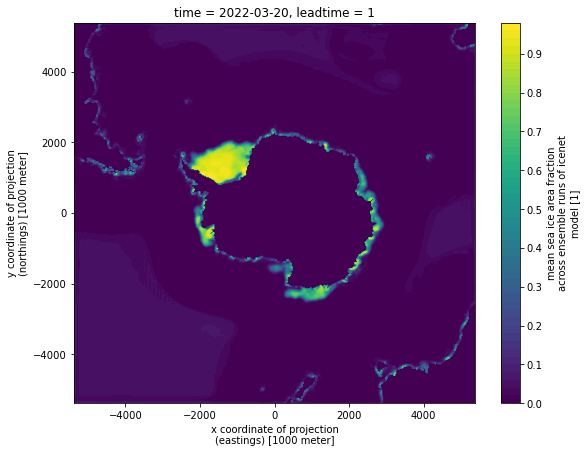

In [49]:
xr.plot.contourf(forecast.isel(dict(leadtime=0, time=0)).sic_mean, levels=50, figsize=(9,7))

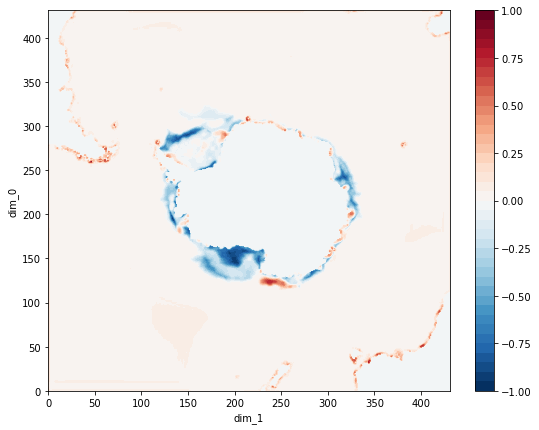

In [50]:
xr.plot.contourf(xr.DataArray(np.flipud(forecast.isel(dict(leadtime=0, time=0)).sic_mean.values - \
                                        np.load("processed/aiuk_run/osisaf/sh/siconca/2017_04_01.npy"))), levels=50, figsize=(9,7))

In [51]:
bda = broadcast_forecast((dt.datetime.now()).strftime("%Y-%m-%d"), 
                         (dt.datetime.now() + dt.timedelta(days = 92)).strftime("%Y-%m-%d"), [filename])
#bda = broadcast_forecast(pd.to_datetime("2017-4-2").strftime("%Y-%m-%d"), 
#                         (pd.to_datetime("2017-4-2") + dt.timedelta(days = 92)).strftime("%Y-%m-%d"), [filename])

anim = xarray_to_video(bda.sic_mean, 15, figsize=4)
HTML(anim.to_html5_video())

INFO:root:Using /data/hpcdata/users/jambyr/icenet/pipeline/results/predict/south_daily_forecast.nc to generate forecast through 2022-03-21 to 2022-06-21
INFO:root:Starting index will be 0 for 2022-03-21 00:00:00 - 2022-06-21 00:00:00
INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation


## Environments and Extensions

### Environments

<img src="pipeline-environments.png" alt="IceNet environments" />


In [27]:
!ls ..
!ls -ld ../pipeline

aiuk-2022  data   hres	   icenet2-aiuk   pipeline
blue	   green  icenet2  notebook-test  scratch
lrwxrwxrwx 1 jambyr its 5 Mar  1 16:38 ../pipeline -> blue/


```bash
0 9 * * * conda activate icenet; \
  cd $HOME/hpc/icenet/pipeline && \
    bash run_daily.sh \
      -d train_HEMI \
      -f `cat FILTER_FACTOR` \
      -o pipeline_HEMI \
      -r run /data/twins/wip/common/icenet \
  >daily.log 2>&1; conda deactivate
```

#### run_daily.sh

* icenet_data_*
* icenet_process_*
* icenet_dataset_create - configuration only mode
* run_predict_ensemble
* icenet_upload

#### Alternatives to cron

* Cylc
* Airflow
* Other workflow managers

### Extensions

The three key areas of the pipeline allow for easy extension:

* Data sourcing (e.g. icenet\_data\_\*)
* Data preprocessing (e.g. icenet\_process\_\*)
* Training and predicting

#### Data extensions

<img src="classhierarchy.png" alt="IceNet basic data hierarchy" />

#### Training and predicting

Instead of a strict class hierarchy assisting with extensions, we allow functional interfacing via the entry points in the relevant `icenet.model` signatures for methods contained in `icenet.model.train` and `icenet.model.predict`.

```python
def train_model(
        run_name,
        dataset_config,
        ...
        model_func=models.unet_batchnorm,
        ...):
    ...
    
    
def predict_forecast(
        dataset_config,
        ...
        model_func=models.unet_batchnorm,
        ...):
    ...
```

Allowing easy integration of new model setups with the CLI. 

## Integrations and Applications

### The IceNet Framework

<img alt="Framework architecture" src="framework.png" style="width:800px" />

#### CF Compliant NetCDF

* icenet_upload_* destinations
* [Access via Azure datastore](https://github.com/alan-turing-institute/IceNetETL#providing-access-to-raw-data)

#### API Access to predictions

* api-usage-latest-forecasts

#### Visual applications

* [My locally hosted toy interface](http://localhost/IceNet-GUI/cesium.html)

### Ecosystem

<img alt="Ecosystem architecture" src="ecosystem.png" style="width:800px" />

#### RoutePlanner and the SDA Digital Twin

<img src="falklands_brunt2020.png" style="width:400px" />

<img src="southsand_longpath2020.png" style="width:600px" />


<!--<video alt="SDA Route Planner" controls src="SDA_RoutePlanner.mp4" type="video/mp4" style="width:800px" />-->

#### C2 glider piloting and the Antarctic Digital Twin

* c2.noc.ac.uk


## Future

### Validation of forecasting

### Digital Twin developments

### External partner collaborations

### Establishing production framework

### Publishing products

#### Research

#### Data

#### Code

## Conclusions

* Research ongoing
* Ecosystem maturing
* Adopters and collaborators

# Q&A